In [20]:
import pandas as pd
import numpy as np
import datetime as dt

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from fbprophet import Prophet
from pmdarima import auto_arima

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, RNN, Input, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
df = pd.read_csv('/kaggle/input/nifty50-stock-market-data/BAJAJFINSV.csv')
df.set_index('Date', drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


In [22]:
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2021-04-26,2021-04-26,BAJAJFINSV,EQ,9916.65,9992.0,10125.00,9902.20,10000.85,10001.75,9995.72,419596,4.194163e+14,45113.0,77816,0.1855
2021-04-27,2021-04-27,BAJAJFINSV,EQ,10001.75,10000.0,10133.00,9964.70,10133.00,10091.35,10036.76,342847,3.441072e+14,40414.0,77723,0.2267
2021-04-28,2021-04-28,BAJAJFINSV,EQ,10091.35,10200.0,10615.95,10151.15,10480.00,10489.30,10445.96,1113881,1.163556e+15,126354.0,133587,0.1199
2021-04-29,2021-04-29,BAJAJFINSV,EQ,10489.30,10540.0,11300.00,10520.00,11175.45,11176.55,10980.40,1696498,1.862822e+15,165425.0,195324,0.1151
2021-04-30,2021-04-30,BAJAJFINSV,EQ,11176.55,11000.0,11225.00,10868.70,11021.00,11041.65,11081.78,835355,9.257223e+14,85986.0,129995,0.1556


In [23]:
df.isna().sum()

Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                745
Deliverable Volume      0
%Deliverble             0
dtype: int64

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Prev Close,3201.0,2.755864e+03,2.869812e+03,9.075000e+01,5.279000e+02,1.098700e+03,5.121900e+03,1.117655e+04
Open,3201.0,2.760382e+03,2.874814e+03,8.815000e+01,5.286000e+02,1.095000e+03,5.120000e+03,1.100000e+04
High,3201.0,2.803614e+03,2.912885e+03,9.310000e+01,5.426000e+02,1.118000e+03,5.199800e+03,1.130000e+04
Low,3201.0,2.716731e+03,2.834037e+03,8.815000e+01,5.200000e+02,1.080250e+03,5.042800e+03,1.086870e+04
Last,3201.0,2.758782e+03,2.873793e+03,9.100000e+01,5.279500e+02,1.100000e+03,5.115000e+03,1.117545e+04
Close,3201.0,2.758657e+03,2.873523e+03,9.075000e+01,5.279000e+02,1.098700e+03,5.125100e+03,1.117655e+04
VWAP,3201.0,2.761157e+03,2.874034e+03,8.926000e+01,5.312700e+02,1.103560e+03,5.127510e+03,1.108178e+04
Volume,3201.0,2.315312e+05,4.402681e+05,4.570000e+02,3.981100e+04,9.995300e+04,2.315400e+05,6.271671e+06
Turnover,3201.0,9.533424e+13,2.176448e+14,1.376712e+10,2.751053e+12,1.090486e+13,8.755946e+13,3.394379e+15
Trades,2456.0,2.089281e+04,3.239630e+04,1.490000e+02,2.951750e+03,9.450000e+03,2.443975e+04,3.129590e+05


In [25]:
df.drop(['Symbol','Series'],axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3201 entries, 2008-05-26 to 2021-04-30
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3201 non-null   object 
 1   Prev Close          3201 non-null   float64
 2   Open                3201 non-null   float64
 3   High                3201 non-null   float64
 4   Low                 3201 non-null   float64
 5   Last                3201 non-null   float64
 6   Close               3201 non-null   float64
 7   VWAP                3201 non-null   float64
 8   Volume              3201 non-null   int64  
 9   Turnover            3201 non-null   float64
 10  Trades              2456 non-null   float64
 11  Deliverable Volume  3201 non-null   int64  
 12  %Deliverble         3201 non-null   float64
dtypes: float64(10), int64(2), object(1)
memory usage: 350.1+ KB


<AxesSubplot:>

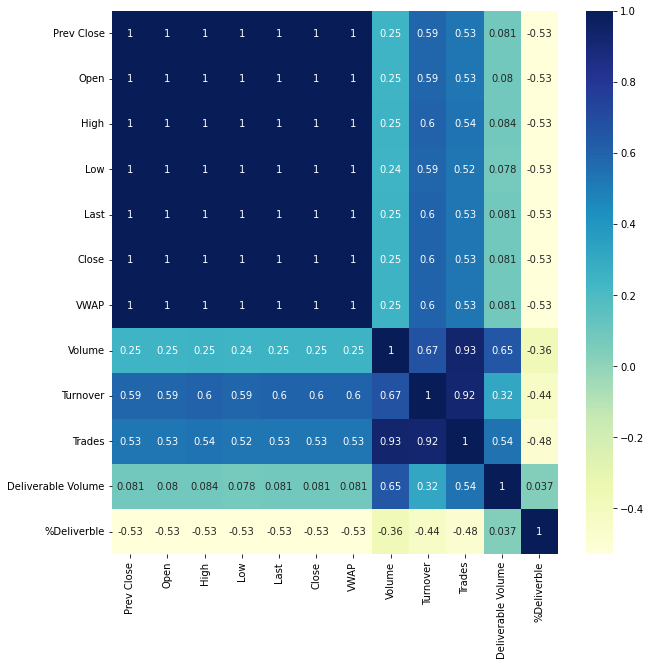

In [26]:
# correlation

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)

In [27]:
df.head()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,
2008-05-26,2008-05-26,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
2008-05-27,2008-05-27,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2008-05-28,2008-05-28,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
2008-05-29,2008-05-29,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
2008-05-30,2008-05-30,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


'Date','Open','High','Low','Volume','VWAP' are highly correlated

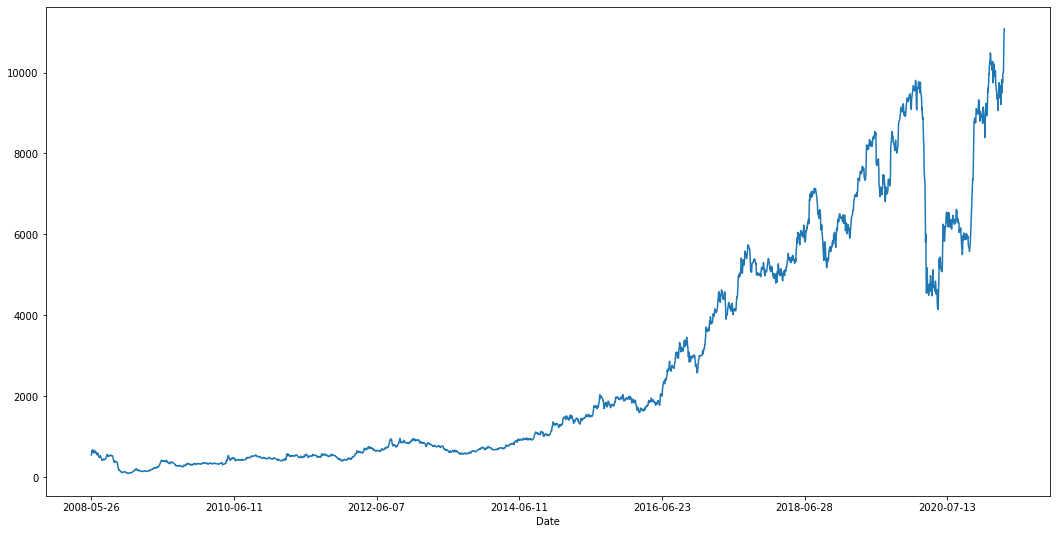

In [28]:
df.VWAP.plot(figsize=(18,9));

## Feature Engineering

In [29]:
df.reset_index(drop=True, inplace=True)
lag_features = ['High','Low','Volume','Turnover','Trades']
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float64)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float64)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float64)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float64)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float64)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float64)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    
df['Daily Return'] = df['Close'].pct_change()

df.fillna(df.mean(), inplace=True)
df.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,Daily Return
0,2008-05-26,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,...,3.202322e+13,4.039685e+13,5.419115e+13,20805.794433,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.001282
1,2008-05-27,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,...,3.202322e+13,4.039685e+13,5.419115e+13,20805.794433,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.089472
2,2008-05-28,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,...,5.388164e+13,5.388164e+13,5.388164e+13,20805.794433,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.155594
3,2008-05-29,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,...,5.682195e+13,5.682195e+13,5.682195e+13,20805.794433,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,-0.013340
4,2008-05-30,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,...,2.541759e+13,5.613884e+13,5.613884e+13,20805.794433,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.018343


For boosting models, it is very useful to add datetime features like hour, day, month, as applicable to provide the model information about the time component in the data. For time series models it is not explicitly required to pass this information

In [30]:
# extracting date time features
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
df['month'] = df.Date.dt.month
df["week"] = df.Date.dt.week
df['day'] = df.Date.dt.month
df['day_of_week'] = df.Date.dt.dayofweek

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', drop=False, inplace=True)

df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,Daily Return,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.001282,5,22,5,0
2008-05-27,2008-05-27,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.089472,5,22,5,1
2008-05-28,2008-05-28,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.155594,5,22,5,2
2008-05-29,2008-05-29,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,-0.013340,5,22,5,3
2008-05-30,2008-05-30,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.018343,5,22,5,4


In [31]:
df.columns

Index(['Date', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP',
       'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble',
       'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30', 'High_std_lag3',
       'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3', 'Low_mean_lag7',
       'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7', 'Low_std_lag30',
       'Volume_mean_lag3', 'Volume_mean_lag7', 'Volume_mean_lag30',
       'Volume_std_lag3', 'Volume_std_lag7', 'Volume_std_lag30',
       'Turnover_mean_lag3', 'Turnover_mean_lag7', 'Turnover_mean_lag30',
       'Turnover_std_lag3', 'Turnover_std_lag7', 'Turnover_std_lag30',
       'Trades_mean_lag3', 'Trades_mean_lag7', 'Trades_mean_lag30',
       'Trades_std_lag3', 'Trades_std_lag7', 'Trades_std_lag30',
       'Daily Return', 'month', 'week', 'day', 'day_of_week'],
      dtype='object')

### AUTO ARIMAX

In [32]:
df_train = df[df.index < '2019']
df_val = df[df.index >= '2019']

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features],
                  trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_val), exogenous=df_val[exogenous_features])
df_val['Forecast_ARIMAX'] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=29839.923, Time=16.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=29813.698, Time=8.79 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=29693.394, Time=8.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30146.473, Time=11.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47846.562, Time=8.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29804.635, Time=11.68 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29897.675, Time=11.66 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=29835.096, Time=13.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29690.916, Time=9.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29803.074, Time=11.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=29895.699, Time=12.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=30144.487, Time=10.90 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29833.633, Time=12.27 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 145.399 second

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The best arima model is (1,0,0) which has the lowest AIC

<AxesSubplot:xlabel='Date'>

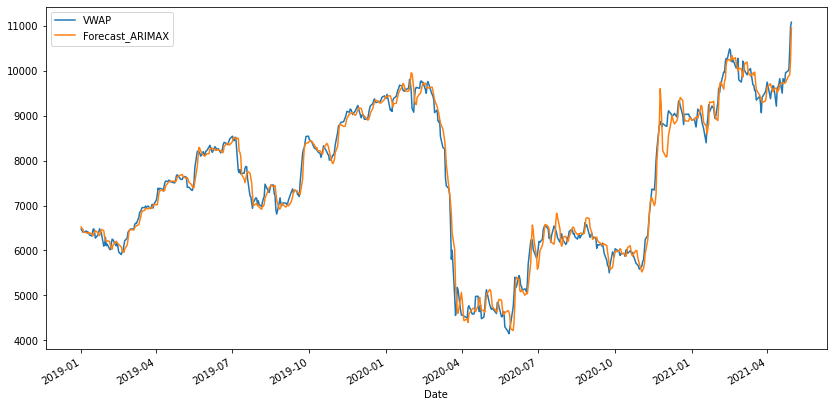

In [33]:
df_val[['VWAP', 'Forecast_ARIMAX']].plot(figsize=(14,7))

In [34]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_val.VWAP, df_val.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_val.VWAP, df_val.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 221.5850133643554

MAE of Auto ARIMAX: 158.05393807462525


### Facebook Prophet

In [35]:
df.head()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,Daily Return,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.001282,5,22,5,0
2008-05-27,2008-05-27,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.089472,5,22,5,1
2008-05-28,2008-05-28,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.155594,5,22,5,2
2008-05-29,2008-05-29,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,-0.013340,5,22,5,3
2008-05-30,2008-05-30,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,...,20746.581891,20480.117038,6680.793876,8337.476575,10924.103467,0.018343,5,22,5,4


In [37]:
df_train = df[df.index < '2019']
df_val = df[df.index >= '2019']
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[['Date', "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_val[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_val["Forecast_Prophet"] = forecast.yhat.values

Initial log joint probability = -112.309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         10241   0.000803794       9020.38      0.9908      0.9908      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10670.5    0.00867515       12669.9           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10901.6    0.00248556       15484.6           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10940.4    0.00315721       16967.1           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10960.6   0.000127211       3131.86      0.3306           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


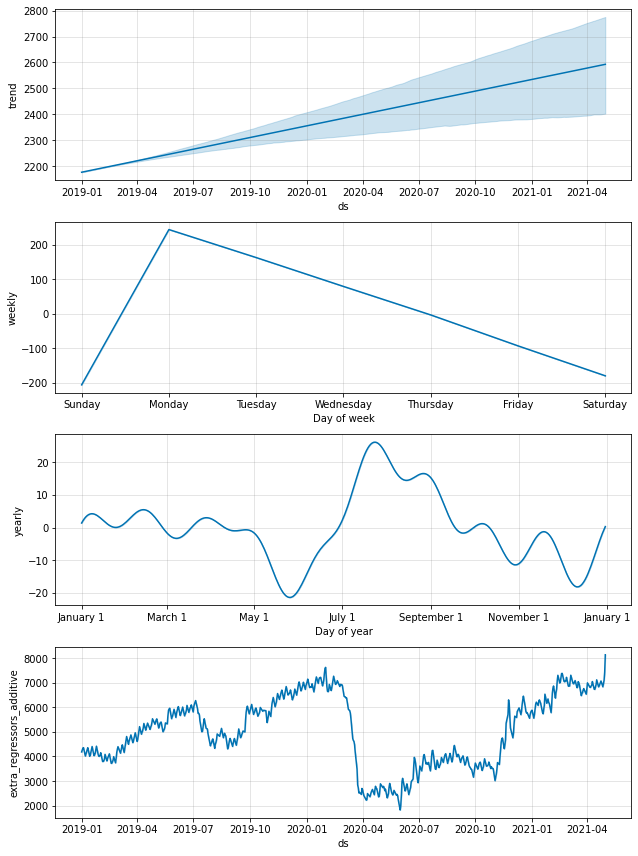

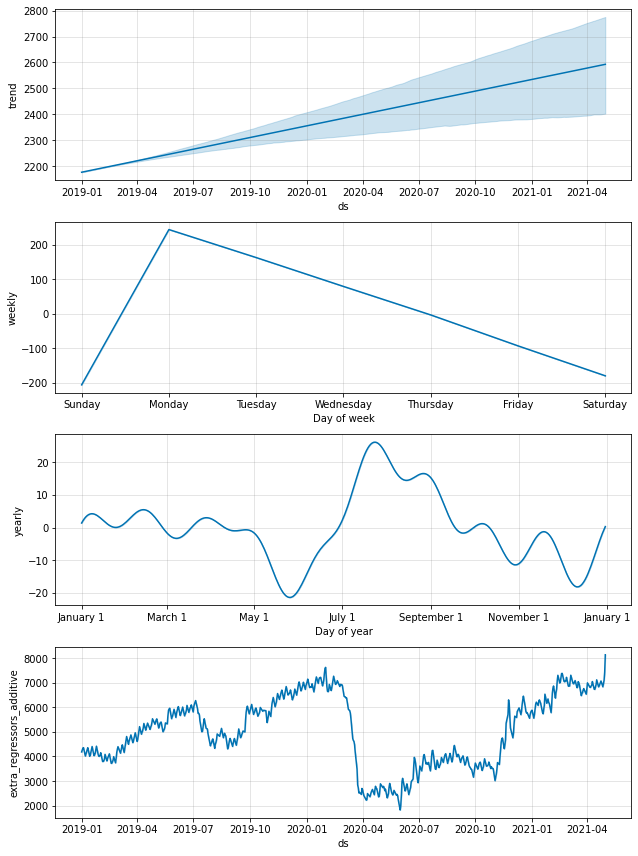

In [38]:
model_fbp.plot_components(forecast)

In [39]:
df_val

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,Daily Return,month,week,day,day_of_week,Forecast_Prophet
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2019-01-01,6476.95,6515.00,6530.00,6418.00,6515.00,6521.95,6477.89,141821,9.187015e+13,...,25891.400000,3679.255541,6442.464143,8638.331714,0.006948,1,1,1,1,6523.952289
2019-01-02,2019-01-02,6521.95,6475.00,6526.00,6360.00,6404.00,6384.00,6440.03,221274,1.425010e+14,...,25664.966667,6356.207229,7878.696538,8888.932489,-0.021152,1,1,1,2,6519.726906
2019-01-03,2019-01-03,6384.00,6439.00,6479.90,6331.65,6390.00,6383.30,6406.39,215845,1.382788e+14,...,25952.466667,5837.918322,5910.286384,8597.574870,-0.000110,1,1,1,3,6513.626555
2019-01-04,2019-01-04,6383.30,6419.95,6460.00,6357.00,6418.00,6410.45,6404.79,156323,1.001216e+14,...,26132.200000,5793.296672,5369.567767,8495.645702,0.004253,1,1,1,4,6445.728033
2019-01-07,2019-01-07,6410.45,6450.50,6500.00,6385.00,6416.00,6407.15,6432.71,103217,6.639650e+13,...,25801.500000,3259.205783,5523.453794,8632.119445,-0.000515,1,2,1,0,6442.447330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,9916.65,9992.00,10125.00,9902.20,10000.85,10001.75,9995.72,419596,4.194163e+14,...,57552.733333,9106.899051,19977.561187,23079.114634,0.008582,4,17,4,0,9661.726326
2021-04-27,2021-04-27,10001.75,10000.00,10133.00,9964.70,10133.00,10091.35,10036.76,342847,3.441072e+14,...,57976.166667,19511.873573,24306.225257,22715.581382,0.008958,4,17,4,1,9714.141227
2021-04-28,2021-04-28,10091.35,10200.00,10615.95,10151.15,10480.00,10489.30,10445.96,1113881,1.163556e+15,...,58140.233333,17161.381364,27488.465739,22564.861224,0.039435,4,17,4,2,9763.927216


<AxesSubplot:xlabel='Date'>

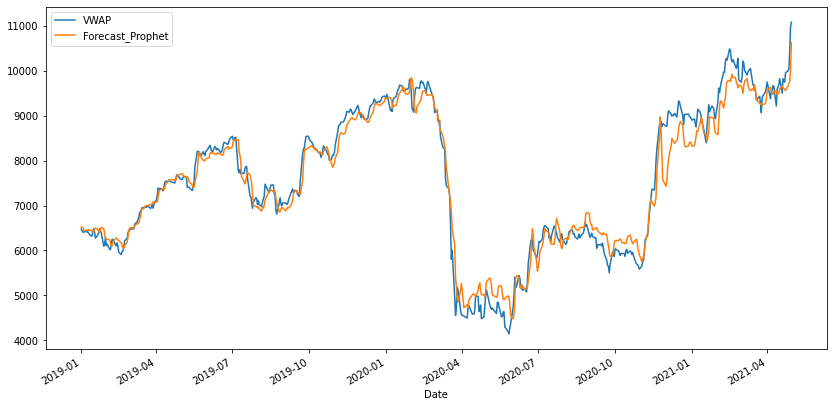

In [42]:
df_val[["VWAP", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [43]:
#print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_val.VWAP, df_val.Forecast_Prophet)))
#print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_val.VWAP, df_val.Forecast_Prophet))

RMSE of Prophet: 317.00116872097954
MAE of Prophet: 233.2866308182746


### Light Gbm

Time series problems are popularly converted into a tabular i.i.d. structure and fed into boosting models like LightGBM and XGBoost.

There is loss of information in terms of knowing the order of data points in the time series but it can be circumvented by the datetime features to capture this information to some extent.

In [44]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_val[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_val[exogenous_features])
df_val["Forecast_LightGBM"] = forecast

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7737
[LightGBM] [Info] Number of data points in the train set: 2624, number of used features: 34
[LightGBM] [Info] Start training from score 1704.727496


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


<AxesSubplot:xlabel='Date'>

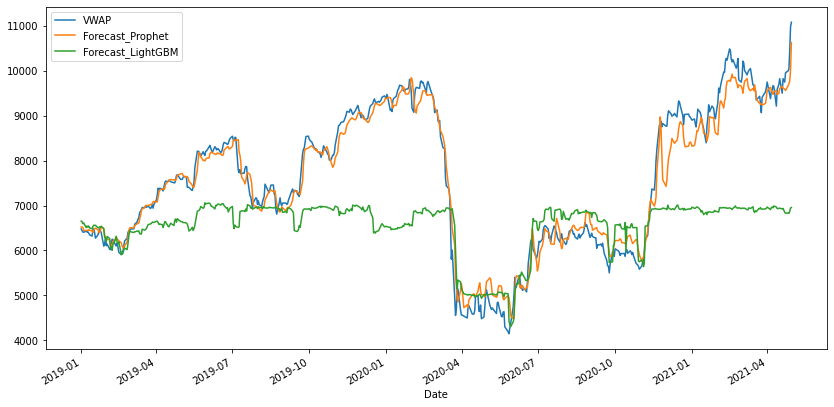

In [46]:
df_val[["VWAP", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

LightGBM performs terribly! This is a very important aspect of using boosting models for time series. Boosting models are constrained to predict within the range of target values appearing in the training data. The maximum price value in the training data is ~ 7100 and hence LGBM is unable to predict values beyond 7100.

One method of improving i.i.d. based models is to model the differential target variable after removing the trend and making the time series stationary.

### XGBoost

In [47]:
# splitting dataset

df_train = df[df.Date < '2019']
df_valid = df[df.Date >= '2019']

print(df_train.shape, df_valid.shape)

(2624, 48) (577, 48)


In [48]:
# scaling n transforming our data

scaler = MinMaxScaler(feature_range=(0,1))

X_train = df_train.drop('VWAP')
X_train = 

SyntaxError: invalid syntax (1398283338.py, line 6)

In [49]:
X_train = df_train.drop(['VWAP','Date'],axis=1)
y_train = df_train['VWAP']

X_valid = df_valid.drop(['VWAP','Date'],axis=1)
y_valid = df_valid['VWAP']

xgb = XGBRegressor(n_estimators=1000,learning_rate=0.01)

xgb.fit(X_train, 
        y_train, 
        eval_set=[(X_train,y_train),(X_valid,y_valid)],early_stopping_rounds=100,verbose=True) 

[0]	validation_0-rmse:2469.11057	validation_1-rmse:7673.13277
[1]	validation_0-rmse:2444.66661	validation_1-rmse:7613.31338
[2]	validation_0-rmse:2420.46609	validation_1-rmse:7554.06231
[3]	validation_0-rmse:2396.50657	validation_1-rmse:7495.59997
[4]	validation_0-rmse:2372.78590	validation_1-rmse:7437.54784
[5]	validation_0-rmse:2349.30146	validation_1-rmse:7380.09573
[6]	validation_0-rmse:2326.05193	validation_1-rmse:7323.65262
[7]	validation_0-rmse:2303.03256	validation_1-rmse:7267.33049


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[8]	validation_0-rmse:2280.24377	validation_1-rmse:7212.04096
[9]	validation_0-rmse:2257.68049	validation_1-rmse:7156.65601
[10]	validation_0-rmse:2235.34289	validation_1-rmse:7102.54344
[11]	validation_0-rmse:2213.22644	validation_1-rmse:7048.09777
[12]	validation_0-rmse:2191.33153	validation_1-rmse:6995.16410
[13]	validation_0-rmse:2169.65317	validation_1-rmse:6941.84849
[14]	validation_0-rmse:2148.19041	validation_1-rmse:6889.03466
[15]	validation_0-rmse:2126.94282	validation_1-rmse:6837.90486
[16]	validation_0-rmse:2105.90488	validation_1-rmse:6786.16645
[17]	validation_0-rmse:2085.07799	validation_1-rmse:6736.06812
[18]	validation_0-rmse:2064.45628	validation_1-rmse:6685.13124
[19]	validation_0-rmse:2044.04177	validation_1-rmse:6636.09790
[20]	validation_0-rmse:2023.82830	validation_1-rmse:6586.12918
[21]	validation_0-rmse:2003.81804	validation_1-rmse:6538.13318
[22]	validation_0-rmse:1984.00434	validation_1-rmse:6489.16085
[23]	validation_0-rmse:1964.39011	validation_1-rmse:6442.

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 864x576 with 0 Axes>

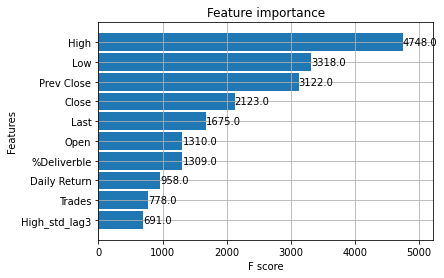

In [50]:
plt.figure(figsize=(12,8))
feature_importance = plot_importance(xgb, height=0.9, max_num_features=10)
feature_importance

In [51]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(y_valid, xgb.predict(X_valid))))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(y_valid, xgb.predict(X_valid)))

RMSE of Auto ARIMAX: 1402.2652781587483

MAE of Auto ARIMAX: 947.7799737665188


### RNN n Friends

In [52]:
def rmse(x, y):
    return np.round(np.sqrt(mean_squared_error(x,y)), 4)   

In [53]:
def create_dataset(df, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back - look_ahead):
        xdat.append(df[i:i+look_back,0])
        ydat.append(df[i+look_back: i+look_back+look_ahead,0])
    
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1, look_ahead)
    return xdat, ydat

In [54]:
def prepare_split(xdat, ydat, cutoff=5000, timesteps=50):
    xtrain, xvalid = xdat[:cutoff, :], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff, :], ydat[cutoff:,]
    
    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)
    
    return xtrain, ytrain, xvalid, yvalid

<AxesSubplot:xlabel='Date'>

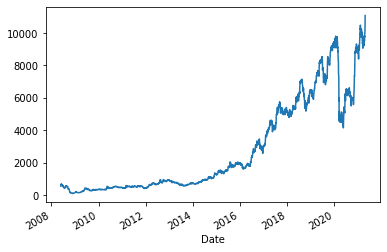

In [65]:
df = pd.read_csv("/kaggle/input/nifty50-stock-market-data/BAJAJFINSV.csv", usecols=['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.VWAP.plot()

    When dealing with time series through RNN we typically - wrappers like Kats or darts notwithstanding - need to format the input data into a shape [batch size, time steps, dimensionality] where the last one is 1 for univariate series (single step ahead predictions) and more for multivariate ones (including univariate series + covariates

In [66]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [67]:
# use 50 historical observation and predict 1 step ahead

look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back, look_ahead)

print(xdat.shape, ydat.shape)

(3150, 50) (3150, 1)


Our prepare_split function takes care of reshaping the data into [batch size, time steps, dimensionality]

In [68]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 3000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(3000, 50, 1) (150, 50, 1) (3000, 1) (150, 1)


In [69]:
# simple RNN model

def create_model():
    model = Sequential()
    model.add(SimpleRNN(10, input_shape=[None, 1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [70]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
           epochs = 10, 
           batch_size = 16, 
           callbacks=[ early_stop])

2022-06-23 09:02:24.692510: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
188/188 [==============================] - 3s 10ms/step - loss: 0.0130 - val_loss: 0.0105
Epoch 2/10
188/188 [==============================] - 2s 8ms/step - loss: 7.1009e-04 - val_loss: 0.0073
Epoch 3/10
188/188 [==============================] - 2s 8ms/step - loss: 5.1681e-04 - val_loss: 0.0050
Epoch 4/10
188/188 [==============================] - 2s 8ms/step - loss: 3.9315e-04 - val_loss: 0.0037
Epoch 5/10
188/188 [==============================] - 2s 8ms/step - loss: 3.1520e-04 - val_loss: 0.0028
Epoch 6/10
188/188 [==============================] - 2s 9ms/step - loss: 2.5192e-04 - val_loss: 0.0025
Epoch 7/10
188/188 [==============================] - 2s 8ms/step - loss: 2.2668e-04 - val_loss: 0.0012
Epoch 8/10
188/188 [==============================] - 2s 8ms/step - loss: 1.9132e-04 - val_loss: 0.0015
Epoch 9/10
188/188 [==============================] - 2s 9ms/step - loss: 1.7089e-04 - val_loss: 0.0014
Epoch 10/10
188/188 [==============================] - 2s 9ms/step 

In [71]:
y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)

In [72]:
print('RMSE:'+str(rmse(y_pred, scaler.inverse_transform(yvalid))))
print('RMSE:'+str(np.sqrt(mean_squared_error(y_pred, yvalid1))))

RMSE:390.5849
RMSE:390.5849199811198


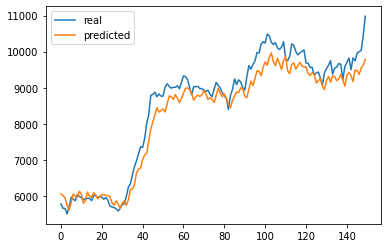

In [73]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

Let's try with 2 RNN layer

By default a recurrent layer only returns the final output - if we want the output for each time step we set return_sequences = True

In [74]:
def create_model():
    model = Sequential()
    model.add(SimpleRNN(10, input_shape=[None, 1], return_sequences=True))
    model.add(SimpleRNN(10, input_shape=[None, 1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 10)          120       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.fit(xtrain, ytrain, 
          validation_data=(xvalid, yvalid),
          epochs = 10, 
          batch_size = 16, 
          callbacks=[ early_stop])

y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)
print('RMSE: ' + str(rmse(y_pred, yvalid1)))

Epoch 1/10
188/188 [==============================] - 5s 19ms/step - loss: 0.0164 - val_loss: 0.0082
Epoch 2/10
188/188 [==============================] - 3s 16ms/step - loss: 7.0235e-04 - val_loss: 0.0080
Epoch 3/10
188/188 [==============================] - 3s 16ms/step - loss: 3.8126e-04 - val_loss: 0.0021
Epoch 4/10
188/188 [==============================] - 3s 16ms/step - loss: 2.7841e-04 - val_loss: 0.0019
Epoch 5/10
188/188 [==============================] - 3s 17ms/step - loss: 2.3800e-04 - val_loss: 9.9905e-04
Epoch 6/10
188/188 [==============================] - 3s 16ms/step - loss: 2.0079e-04 - val_loss: 0.0010
Epoch 7/10
188/188 [==============================] - 3s 16ms/step - loss: 1.8342e-04 - val_loss: 9.7589e-04
Epoch 8/10
188/188 [==============================] - 3s 17ms/step - loss: 1.6046e-04 - val_loss: 9.3460e-04
Epoch 9/10
188/188 [==============================] - 3s 18ms/step - loss: 1.4794e-04 - val_loss: 7.1904e-04
Epoch 10/10
188/188 [======================

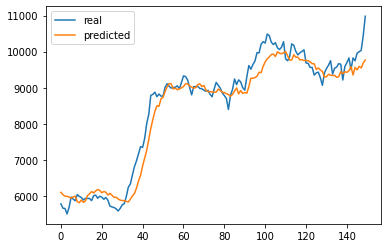

In [76]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

Our model definitely got better!

Let's replicate the above to predict multiple steps ahead(making it a many-to-many problem)

In [77]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back, look_ahead)
print(xdat.shape, ydat.shape)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 3000, timesteps= look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(3141, 50) (3141, 10)
(3000, 50, 1) (141, 50, 1) (3000, 10) (141, 10)


In [78]:
def create_model(out_dim):
    model=Sequential()
    model.add(SimpleRNN(10, input_shape=[None, 1], return_sequences=True))
    model.add(SimpleRNN(10, input_shape=[None, 1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model(look_ahead)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, None, 10)          120       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.fit(xtrain, ytrain,
          validation_data=(xvalid, yvalid),
          epochs = 10, 
          batch_size = 16, 
          callbacks=[ early_stop])

y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)
print('RMSE:'+ str(rmse(y_pred, yvalid1)))

Epoch 1/10
188/188 [==============================] - 5s 18ms/step - loss: 0.0229 - val_loss: 0.0178
Epoch 2/10
188/188 [==============================] - 4s 22ms/step - loss: 0.0014 - val_loss: 0.0098
Epoch 3/10
188/188 [==============================] - 4s 19ms/step - loss: 9.0238e-04 - val_loss: 0.0058
Epoch 4/10
188/188 [==============================] - 4s 24ms/step - loss: 7.0297e-04 - val_loss: 0.0057
Epoch 5/10
188/188 [==============================] - 3s 16ms/step - loss: 6.3791e-04 - val_loss: 0.0035
Epoch 6/10
188/188 [==============================] - 3s 16ms/step - loss: 5.8426e-04 - val_loss: 0.0036
Epoch 7/10
188/188 [==============================] - 3s 17ms/step - loss: 5.5607e-04 - val_loss: 0.0047
Epoch 8/10
188/188 [==============================] - 3s 16ms/step - loss: 5.2095e-04 - val_loss: 0.0039
Epoch 9/10
188/188 [==============================] - 4s 19ms/step - loss: 5.0273e-04 - val_loss: 0.0030
Epoch 10/10
188/188 [==============================] - 3s 17ms/

In [80]:
y_pred

array([[6001.0234, 6218.703 , 6397.728 , ..., 6509.3257, 6219.485 ,
        6059.9194],
       [5936.2983, 6082.3433, 6452.1143, ..., 6476.9756, 6088.462 ,
        5962.432 ],
       [5812.745 , 5887.737 , 6384.852 , ..., 6360.5093, 5981.196 ,
        5866.8867],
       ...,
       [9390.269 , 9668.342 , 8877.153 , ..., 8889.462 , 9291.319 ,
        9156.524 ],
       [9233.993 , 9688.838 , 8946.748 , ..., 9011.803 , 9091.5   ,
        8925.025 ],
       [9252.491 , 9403.764 , 8944.004 , ..., 8961.986 , 9175.713 ,
        8983.06  ]], dtype=float32)

The performance of our RNN model starts to suffer for longer time horizons. It is in general expected with all forecasting models if we go far enough, but with RNN the problem tends to be acute.

    *at each step the gradient is calculated and used to update weights in the network
    *small magnitude  ⟹  exponential decay (or growth!) through time
    *network fails to learn earlier inputs
    *network "forgets" the first input

### GRU

Same workflow, different operation inside a unit

    * used a hidden state

    * two gates: reset and update  →  control how much / which information to retain

    * reset gate: used to decide whether the previous cell state is important or not; not always used. If close to 0, previous hidden state is mostly ignored: model drops information irrelevant to the future.

    * update gate: decides if the cell state should be updated with the candidate state (current activation value) or not. If close to 1, we can copy information in that unit through subsequent steps

    * candidate cell: hidden state(activation) of RNN

    * final cell state: dependent on the update gate, It may or may not be updated with candidate state. Remove some content from last cell state, and write some new cell content. In GRU the final cell state is directly passing as the activation to the next cell.

In [81]:
def create_model(out_dim):
    model = Sequential()
    model.add(GRU(10, input_shape=[None, 1], return_sequences=True))
    model.add(GRU(10, input_shape=[None, 1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model(look_ahead)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 10)          390       
_________________________________________________________________
gru_3 (GRU)                  (None, 10)                660       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
Total params: 1,160
Trainable params: 1,160
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.fit(xtrain, ytrain,
          validation_data=(xvalid, yvalid),
          epochs = 10, 
          batch_size = 16, 
          callbacks=[early_stop])

y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)
print('RMSE:'+ str(rmse(y_pred, yvalid1)))

Epoch 1/10
188/188 [==============================] - 15s 55ms/step - loss: 0.0277 - val_loss: 0.0126
Epoch 2/10
188/188 [==============================] - 9s 47ms/step - loss: 8.1552e-04 - val_loss: 0.0067
Epoch 3/10
188/188 [==============================] - 9s 50ms/step - loss: 6.1110e-04 - val_loss: 0.0055
Epoch 4/10
188/188 [==============================] - 9s 46ms/step - loss: 5.4479e-04 - val_loss: 0.0035
Epoch 5/10
188/188 [==============================] - 9s 47ms/step - loss: 5.2411e-04 - val_loss: 0.0039
Epoch 6/10
188/188 [==============================] - 10s 51ms/step - loss: 4.9355e-04 - val_loss: 0.0031
Epoch 7/10
188/188 [==============================] - 9s 47ms/step - loss: 4.7804e-04 - val_loss: 0.0030
Epoch 8/10
188/188 [==============================] - 9s 47ms/step - loss: 4.6603e-04 - val_loss: 0.0038
Epoch 9/10
188/188 [==============================] - 9s 47ms/step - loss: 4.3875e-04 - val_loss: 0.0032
Restoring model weights from the end of the best epoch.
E

### LSTM

A second popular approach to handling the issues with RNN is using Long Short-Term Memory units:

    * LSTM have two more gates compared to GRU: forget and output.

    * Forget gate: controls what is kept vs forgotten, from previous cell state. In laymen terms, it will decide how much information from the previous state should be kept and forget remaining.

    * Output gate: controls which parts of the cell are output to the hidden state. It will determine what the next hidden state will be.

In [83]:
def create_model(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model = create_model(look_ahead)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 10)          480       
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
Total params: 1,430
Trainable params: 1,430
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.fit(xtrain, ytrain,
          validation_data=(xvalid, yvalid),
          epochs = 10, 
          batch_size = 16, 
          callbacks=[early_stop])

y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)
print('RMSE:'+ str(rmse(y_pred, yvalid1)))

Epoch 1/10
188/188 [==============================] - 10s 33ms/step - loss: 0.0156 - val_loss: 0.0132
Epoch 2/10
188/188 [==============================] - 6s 29ms/step - loss: 0.0013 - val_loss: 0.0120
Epoch 3/10
188/188 [==============================] - 5s 27ms/step - loss: 0.0011 - val_loss: 0.0094
Epoch 4/10
188/188 [==============================] - 5s 28ms/step - loss: 9.5301e-04 - val_loss: 0.0066
Epoch 5/10
188/188 [==============================] - 5s 27ms/step - loss: 7.9114e-04 - val_loss: 0.0042
Epoch 6/10
188/188 [==============================] - 5s 27ms/step - loss: 7.2023e-04 - val_loss: 0.0050
Epoch 7/10
188/188 [==============================] - 5s 27ms/step - loss: 6.7381e-04 - val_loss: 0.0052
Epoch 8/10
188/188 [==============================] - 5s 29ms/step - loss: 6.2566e-04 - val_loss: 0.0047
Epoch 9/10
188/188 [==============================] - 5s 28ms/step - loss: 6.2491e-04 - val_loss: 0.0043
Epoch 10/10
188/188 [==============================] - 5s 27ms/ste